In [1]:
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import ast
from pymongo import MongoClient
import concurrent.futures


In [2]:
client = MongoClient('mongodb://localhost:27017/')

db = client['spotify']
collection = db['raw']


In [3]:
# Initialize scaler and PCA
scaler = StandardScaler()
pca = PCA(n_components=0.95) 


In [5]:
df = pd.read_csv('/home/shahbaz/Desktop/bda_project/fma_metadata/raw_tracks.csv',index_col=False)
df.head()

,track_id,album_id,album_title,album_url,artist_id,artist_name,artist_url,artist_website,license_image_file,license_image_file_large,...,track_information,track_instrumental,track_interest,track_language_code,track_listens,track_lyricist,track_number,track_publisher,track_title,track_url
0,2,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,4656,en,1293,NaN,3,NaN,Food,http://freemusicarchive.org/music/AWOL/AWOL_-_...
1,3,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1470,en,514,NaN,4,NaN,Electric Ave,http://freemusicarchive.org/music/AWOL/AWOL_-_...
2,5,1.0,AWOL - A Way Of Life,http://freemusicarchive.org/music/AWOL/AWOL_-_...,1,AWOL,http://freemusicarchive.org/music/AWOL/,http://www.AzillionRecords.blogspot.com,http://i.creativecommons.org/l/by-nc-sa/3.0/us...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,1933,en,1151,NaN,6,NaN,This World,http://freemusicarchive.org/music/AWOL/AWOL_-_...
3,10,6.0,Constant Hitmaker,http://freemusicarchive.org/music/Kurt_Vile/Co...,6,Kurt Vile,http://freemusicarchive.org/music/Kurt_Vile/,http://kurtvile.com,http://i.creativecommons.org/l/by-nc-nd/3.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,54881,en,50135,NaN,1,NaN,Freeway,http://freemusicarchive.org/music/Kurt_Vile/Co...
4,20,4.0,Niris,http://freemusicarchive.org/music/Chris_and_Ni...,4,Nicky Cook,http://freemusicarchive.org/music/Chris_and_Ni...,NaN,http://i.creativecommons.org/l/by-nc-nd/3.0/88...,http://fma-files.s3.amazonaws.com/resources/im...,...,NaN,0,978,en,361,NaN,3,NaN,Spiritual Level,http://freemusicarchive.org/music/Chris_and_Ni...


In [6]:
df = df.drop(columns=['album_url','artist_id','album_id','track_date_created','track_duration','track_comments','track_composer','track_interest','track_explicit','track_favorites','track_copyright_c','track_disc_number','track_date_recorded','track_interest','track_explicit_notes','license_url','tags', 'track_copyright_p','artist_url','artist_website','track_bit_rate','license_image_file','license_image_file_large','license_title','track_information','track_instrumental','track_language_code','track_lyricist','track_number','track_publisher','track_url','track_image_file','track_file','license_parent_id'])
df.tail()

,track_id,album_title,artist_name,track_genres,track_listens,track_title
109722,155316,"Live at Monty Hall, 2/17/2017",Spowder,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",102,The Auger
109723,155317,"Live at Monty Hall, 2/17/2017",Spowder,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",165,Let's Skin Ruby
109724,155318,"Live at Monty Hall, 2/17/2017",Spowder,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",168,My House Smells Like Kim Deal/Pulp
109725,155319,"Live at Monty Hall, 2/17/2017",Spowder,"[{'genre_id': '25', 'genre_title': 'Punk', 'ge...",294,The Man With Two Mouths
109726,155320,What I Tell Myself Vol. 2,Forget the Whale,"[{'genre_id': '10', 'genre_title': 'Pop', 'gen...",705,Another Trick Up My Sleeve (Instrumental)


In [7]:
df.to_csv('/home/shahbaz/Desktop/bda_project/fma_metadata/clean.csv',index=False)


In [8]:
df1=pd.read_csv('/home/shahbaz/Desktop/bda_project/fma_metadata/raw_tracks_clean.csv')
print(df1.columns)
print(df1.shape)

Index(['track_id', 'album_title', 'artist_name', 'track_genres',
       'track_listens', 'track_title'],
      dtype='object')
(109727, 6)


In [9]:
def preprocess_genres(genre_string):
        try:
            genres_list = ast.literal_eval(genre_string)
            genre_ids = ','.join([genre['genre_id'] for genre in genres_list])
            genre_titles = ','.join([genre['genre_title'] for genre in genres_list])
            return genre_ids,genre_titles
        except:
            return "Error in genre parsing"

In [10]:
def extractFeatures(file_path, metadata, client_uri="mongodb://localhost:27017/"):
    track_id = int(os.path.basename(file_path).replace('.mp3', ''))
    client = MongoClient(client_uri)
    db = client['spotify']
    collection = db['raw']
    
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30, n_fft=2048, hop_length=512)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        harmonic_y = librosa.effects.harmonic(y)
        tonnetz = librosa.feature.tonnetz(y=harmonic_y, sr=sr)
        
        mfccs_mean = np.mean(mfccs, axis=1)
        chroma_mean = np.mean(chroma, axis=1)
        spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
        tonnetz_mean = np.mean(tonnetz, axis=1)

        features = np.hstack((mfccs_mean, chroma_mean, spectral_contrast_mean, tonnetz_mean)).tolist()
        
        if track_id in metadata['track_id'].values:
            track_info = metadata[metadata['track_id'] == track_id].iloc[0]
            ID, title = preprocess_genres(track_info['track_genres'])
            listens = int(track_info['track_listens']) if isinstance(track_info['track_listens'], np.integer) else track_info['track_listens']
            record = {
                '_id': track_id,
                'features': features,
                'album_title': track_info['album_title'],
                'artist_name': track_info['artist_name'],
                'genres_id': ID,
                'genres_title': title,
                'listens': listens,
                'track_title': track_info['track_title']
            }
            collection.insert_one(record)
            print(f"Record for track_id {track_id} inserted successfully.")
        else:
            print(f"No metadata found for track_id {track_id}")
            collection.insert_one({'_id': track_id, 'error': 'Metadata not found'})
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
    finally:
        client.close()


In [11]:
# Testing with 1 file 
file_path = '/home/shahbaz/Desktop/bda_project/SampleData/000/000002.mp3'
test_output = extractFeatures(file_path, df1)
print(test_output)



Record for track_id 2 inserted successfully.
None


In [12]:
def process_batch(paths, metadata):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = [executor.submit(extractFeatures, path, metadata) for path in paths]
        results = [future.result() for future in concurrent.futures.as_completed(futures)]
    return results

In [13]:
def list_files(base_path):
    folders_files = {}
    for root, dirs, files in os.walk(base_path):
        mp3_files = [os.path.join(root, file) for file in files if file.endswith('.mp3')]
        if mp3_files:
            folders_files[root] = mp3_files
    return folders_files

In [14]:
def process_all_folders(base_path, df, batch_size=200):
    folders_files = list_files(base_path)
    all_results = []
    for folder, files in folders_files.items():
        print(f"Processing folder {folder} with {len(files)} files")
        for i in range(0, len(files), batch_size):
            batch_files = files[i:i+batch_size]
            batch_results = process_batch(batch_files, df)
            all_results.extend(batch_results)
    return all_results


In [15]:
# Base path to your dataset
Folder = '/home/shahbaz/Desktop/bda_project/sample'

# Process the dataset
features = process_all_folders(Folder, df1, batch_size=200)  

Processing folder /home/shahbaz/Desktop/bda_project/sample/077 with 366 files


Error processing /home/shahbaz/Desktop/bda_project/sample/077/077480.mp3: too many values to unpack (expected 2)
Error processing /home/shahbaz/Desktop/bda_project/sample/077/077485.mp3: too many values to unpack (expected 2)
Record for track_id 77753 inserted successfully.
Record for track_id 77414 inserted successfully.
Record for track_id 77219 inserted successfully.
Record for track_id 77378 inserted successfully.
Record for track_id 77724 inserted successfully.
Record for track_id 77304 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/077/077499.mp3: too many values to unpack (expected 2)Record for track_id 77959 inserted successfully.

Record for track_id 77386 inserted successfully.
Record for track_id 77376 inserted successfully.
Record for track_id 77153 inserted successfully.
Record for track_id 77581 inserted successfully.
Record for track_id 77320 inserted successfully.
Record for track_id 77384 inserted successfully.
Record for track_id 7756

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1775
  warnings.warn(
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=888
  warnings.warn(
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=444
  warnings.warn(
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=222
  warnings.warn(
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=111
  warnings.warn(
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=56
  warnings.warn(
/home/shah

Record for track_id 85863 inserted successfully.
Record for track_id 85219 inserted successfully.
Record for track_id 85941 inserted successfully.
Record for track_id 85714 inserted successfully.
Record for track_id 85227 inserted successfully.
Record for track_id 85886 inserted successfully.
Record for track_id 85832 inserted successfully.
Record for track_id 85014 inserted successfully.
Record for track_id 85591 inserted successfully.
Record for track_id 85705 inserted successfully.
Record for track_id 85317 inserted successfully.
Record for track_id 85291 inserted successfully.
Record for track_id 85277 inserted successfully.
Record for track_id 85907 inserted successfully.
Record for track_id 85213 inserted successfully.
Record for track_id 85240 inserted successfully.
Record for track_id 85642 inserted successfully.
Record for track_id 85781 inserted successfully.
Record for track_id 85274 inserted successfully.
Record for track_id 85931 inserted successfully.
Record for track_id 

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Record for track_id 85434 inserted successfully.
Record for track_id 85894 inserted successfully.
Record for track_id 85433 inserted successfully.
Record for track_id 85842 inserted successfully.
Record for track_id 85207 inserted successfully.
Record for track_id 85498 inserted successfully.
Record for track_id 85220 inserted successfully.
Record for track_id 85387 inserted successfully.
Record for track_id 85613 inserted successfully.Record for track_id 85650 inserted successfully.

Record for track_id 85135 inserted successfully.
Record for track_id 85445 inserted successfully.
Record for track_id 85416 inserted successfully.
Record for track_id 85829 inserted successfully.
Record for track_id 85041 inserted successfully.
Record for track_id 85008 inserted successfully.
Record for track_id 85868 inserted successfully.
Record for track_id 85366 inserted successfully.
Record for track_id 85011 inserted successfully.
Record for track_id 85352 inserted successfully.
Record for track_id 

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Record for track_id 40421 inserted successfully.
Record for track_id 40833 inserted successfully.
Record for track_id 40308 inserted successfully.
Record for track_id 40248 inserted successfully.
Record for track_id 40576 inserted successfully.
Record for track_id 40962 inserted successfully.
Record for track_id 40827 inserted successfully.
Record for track_id 40292 inserted successfully.
Record for track_id 40749 inserted successfully.
Record for track_id 40501 inserted successfully.
Record for track_id 40856 inserted successfully.
Record for track_id 40943 inserted successfully.
Record for track_id 40186 inserted successfully.
Record for track_id 40839 inserted successfully.
Record for track_id 40770 inserted successfully.Record for track_id 40955 inserted successfully.

Record for track_id 40876 inserted successfully.
Record for track_id 40695 inserted successfully.
Record for track_id 40006 inserted successfully.
Record for track_id 40886 inserted successfully.
Record for track_id 

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Record for track_id 52834 inserted successfully.
Record for track_id 52040 inserted successfully.
Record for track_id 52439 inserted successfully.
Record for track_id 52524 inserted successfully.
Record for track_id 52741 inserted successfully.
Record for track_id 52686 inserted successfully.
Record for track_id 52511 inserted successfully.
Record for track_id 52585 inserted successfully.
Record for track_id 52583 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/052/052065.mp3: too many values to unpack (expected 2)
Record for track_id 52211 inserted successfully.
Record for track_id 52912 inserted successfully.
Record for track_id 52333 inserted successfully.
Record for track_id 52597 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/052/052073.mp3: too many values to unpack (expected 2)
Record for track_id 52839 inserted successfully.
Record for track_id 52922 inserted successfully.Record for track_id 52221 inserted succe

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/052/052640.mp3: 
Record for track_id 52952 inserted successfully.
Record for track_id 52310 inserted successfully.
Record for track_id 52115 inserted successfully.
Record for track_id 52173 inserted successfully.
Record for track_id 52108 inserted successfully.
Record for track_id 52954 inserted successfully.
Record for track_id 52309 inserted successfully.
Record for track_id 52316 inserted successfully.
Record for track_id 52499 inserted successfully.
Record for track_id 52719 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/052/052977.mp3: too many values to unpack (expected 2)
Record for track_id 52649 inserted successfully.
Record for track_id 52631 inserted successfully.
Record for track_id 52998 inserted successfully.
Record for track_id 52985 inserted successfully.
Record for track_id 52476 inserted successfully.
Record for track_id 52237 inserted successfully.
Record for track_id 52756 in

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Record for track_id 52593 inserted successfully.
Record for track_id 52721 inserted successfully.
Record for track_id 52329 inserted successfully.
Record for track_id 52663 inserted successfully.
Record for track_id 52517 inserted successfully.
Record for track_id 52738 inserted successfully.
Record for track_id 52957 inserted successfully.
Record for track_id 52455 inserted successfully.
Record for track_id 52190 inserted successfully.
Record for track_id 52114 inserted successfully.
Record for track_id 52413 inserted successfully.
Record for track_id 52961 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/052/052892.mp3: too many values to unpack (expected 2)
Record for track_id 52210 inserted successfully.
Record for track_id 52273 inserted successfully.
Processing folder /home/shahbaz/Desktop/bda_project/sample/110 with 677 files
Record for track_id 110518 inserted successfully.
Record for track_id 110490 inserted successfully.
Record for track_id 110

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=954
  warnings.warn(


Record for track_id 110003 inserted successfully.
Record for track_id 110419 inserted successfully.
Record for track_id 110584 inserted successfully.
Record for track_id 110991 inserted successfully.
Record for track_id 110746 inserted successfully.
Record for track_id 110463 inserted successfully.
Record for track_id 110259 inserted successfully.
Record for track_id 110857 inserted successfully.
Record for track_id 110795 inserted successfully.
Record for track_id 110739 inserted successfully.
Record for track_id 110689 inserted successfully.
Record for track_id 110246 inserted successfully.
Record for track_id 110149 inserted successfully.
Record for track_id 110237 inserted successfully.
Record for track_id 110784 inserted successfully.
Record for track_id 110051 inserted successfully.
Record for track_id 110923 inserted successfully.
Record for track_id 110859 inserted successfully.
Record for track_id 110736 inserted successfully.
Record for track_id 110369 inserted successfully.


/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/110/110236.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 110626 inserted successfully.
Record for track_id 110718 inserted successfully.
Record for track_id 110581 inserted successfully.
Record for track_id 110161 inserted successfully.
Record for track_id 110390 inserted successfully.
Record for track_id 110595 inserted successfully.
Record for track_id 110385 inserted successfully.
Record for track_id 110967 inserted successfully.
Record for track_id 110670 inserted successfully.
Record for track_id 110632 inserted successfully.
Record for track_id 110176 inserted successfully.
Record for track_id 110657 inserted successfully.
Record for track_id 110794 inserted successfully.
Record for track_id 110108 inserted successfully.
Record for track_id 110690 inserted successfully.
Record for track_id 110360 inserted successfully.
Record for track_id 110030 inserted successfully.
Record for track_id 110678 inserted successfully.
Record for track_id 110008 inserted successfully.
Record for track_id 110461 inserted successfully.


/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Record for track_id 110018 inserted successfully.
Record for track_id 110515 inserted successfully.
Record for track_id 110075 inserted successfully.
Record for track_id 110634 inserted successfully.
Record for track_id 110535 inserted successfully.
Record for track_id 110701 inserted successfully.
Record for track_id 110341 inserted successfully.
Record for track_id 110332 inserted successfully.
Record for track_id 110591 inserted successfully.
Record for track_id 110095 inserted successfully.
Record for track_id 110676 inserted successfully.
Record for track_id 110655 inserted successfully.
Record for track_id 110612 inserted successfully.
Record for track_id 110009 inserted successfully.
Record for track_id 110755 inserted successfully.
Record for track_id 110175 inserted successfully.
Record for track_id 110089 inserted successfully.
Record for track_id 110675 inserted successfully.
Record for track_id 110076 inserted successfully.
Record for track_id 110205 inserted successfully.


[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Record for track_id 110207 inserted successfully.
Record for track_id 110195 inserted successfully.
Record for track_id 110793 inserted successfully.
Record for track_id 110645 inserted successfully.
Record for track_id 110779 inserted successfully.
Record for track_id 110414 inserted successfully.
Record for track_id 110409 inserted successfully.
Record for track_id 110733 inserted successfully.
Record for track_id 110639 inserted successfully.
Record for track_id 110338 inserted successfully.
Record for track_id 110042 inserted successfully.
Record for track_id 110096 inserted successfully.
Record for track_id 110139 inserted successfully.
Record for track_id 110168 inserted successfully.
Record for track_id 110608 inserted successfully.
Record for track_id 110745 inserted successfully.
Record for track_id 110680 inserted successfully.
Record for track_id 110788 inserted successfully.
Record for track_id 110135 inserted successfully.
Record for track_id 110538 inserted successfully.


/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Record for track_id 59715 inserted successfully.
Record for track_id 59219 inserted successfully.
Record for track_id 59388 inserted successfully.
Record for track_id 59713 inserted successfully.
Record for track_id 59164 inserted successfully.
Record for track_id 59605 inserted successfully.
Record for track_id 59075 inserted successfully.
Record for track_id 59225 inserted successfully.
Record for track_id 59888 inserted successfully.
Record for track_id 59734 inserted successfully.
Record for track_id 59047 inserted successfully.
Record for track_id 59564 inserted successfully.
Record for track_id 59194 inserted successfully.
Record for track_id 59765 inserted successfully.
Record for track_id 59916 inserted successfully.
Record for track_id 59843 inserted successfully.
Record for track_id 59255 inserted successfully.
Record for track_id 59058 inserted successfully.
Record for track_id 59633 inserted successfully.
Record for track_id 59407 inserted successfully.
Record for track_id 

Note: Illegal Audio-MPEG-Header 0x07000000 at offset 617910.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Record for track_id 59817 inserted successfully.
Record for track_id 59702 inserted successfully.
Record for track_id 59845 inserted successfully.
Record for track_id 59962 inserted successfully.
Record for track_id 59077 inserted successfully.
Record for track_id 59154 inserted successfully.
Record for track_id 59621 inserted successfully.
Record for track_id 59764 inserted successfully.
Record for track_id 59544 inserted successfully.
Processing folder /home/shahbaz/Desktop/bda_project/sample/049 with 530 files
Record for track_id 49915 inserted successfully.
Record for track_id 49292 inserted successfully.
Record for track_id 49388 inserted successfully.
Record for track_id 49529 inserted successfully.
Record for track_id 49821 inserted successfully.
Record for track_id 49263 inserted successfully.
Record for track_id 49040 inserted successfully.
Record for track_id 49063 inserted successfully.
Record for track_id 49614 inserted successfully.
Record for track_id 49452 inserted succe

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/095/095253.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 95185 inserted successfully.
Record for track_id 95782 inserted successfully.
Record for track_id 95469 inserted successfully.
Record for track_id 95758 inserted successfully.
Record for track_id 95052 inserted successfully.
Record for track_id 95289 inserted successfully.
Record for track_id 95924 inserted successfully.
Record for track_id 95199 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/095/095277.mp3: too many values to unpack (expected 2)
Record for track_id 95356 inserted successfully.
Record for track_id 95757 inserted successfully.
Record for track_id 95685 inserted successfully.
Record for track_id 95049 inserted successfully.
Record for track_id 95701 inserted successfully.
Record for track_id 95344 inserted successfully.
Record for track_id 95796 inserted successfully.
Record for track_id 95207 inserted successfully.
Record for track_id 95674 inserted successfully.
Record for track_id 95383 inserted successfully.
Recor

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Record for track_id 16384 inserted successfully.
Record for track_id 16163 inserted successfully.
Record for track_id 16828 inserted successfully.
Record for track_id 16852 inserted successfully.
Record for track_id 16523 inserted successfully.
Record for track_id 16444 inserted successfully.
Record for track_id 16107 inserted successfully.
Record for track_id 16356 inserted successfully.
Record for track_id 16836 inserted successfully.
Record for track_id 16652 inserted successfully.
Record for track_id 16784 inserted successfully.
Record for track_id 16385 inserted successfully.
Record for track_id 16559 inserted successfully.
Record for track_id 16105 inserted successfully.
Record for track_id 16696 inserted successfully.
Record for track_id 16126 inserted successfully.
Record for track_id 16192 inserted successfully.
Record for track_id 16062 inserted successfully.
Record for track_id 16786 inserted successfully.
Record for track_id 16653 inserted successfully.
Record for track_id 

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Record for track_id 16149 inserted successfully.
Record for track_id 16783 inserted successfully.
Record for track_id 16281 inserted successfully.
Record for track_id 16029 inserted successfully.
Record for track_id 16113 inserted successfully.
Record for track_id 16271 inserted successfully.
Record for track_id 16799 inserted successfully.
Record for track_id 16585 inserted successfully.
Record for track_id 16013 inserted successfully.
Record for track_id 16760 inserted successfully.
Record for track_id 16857 inserted successfully.
Record for track_id 16754 inserted successfully.
Record for track_id 16728 inserted successfully.
Record for track_id 16928 inserted successfully.
Record for track_id 16030 inserted successfully.
Record for track_id 16592 inserted successfully.
Record for track_id 16685 inserted successfully.
Record for track_id 16381 inserted successfully.
Record for track_id 16779 inserted successfully.
Record for track_id 16896 inserted successfully.
Record for track_id 

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (3264) too large for available bit count (3224)


Record for track_id 16055 inserted successfully.
Record for track_id 16850 inserted successfully.
Record for track_id 16402 inserted successfully.
Record for track_id 16664 inserted successfully.
Record for track_id 16322 inserted successfully.
Record for track_id 16596 inserted successfully.
Record for track_id 16224 inserted successfully.
Record for track_id 16772 inserted successfully.
Record for track_id 16603 inserted successfully.
Record for track_id 16821 inserted successfully.
Record for track_id 16721 inserted successfully.
Record for track_id 16558 inserted successfully.
Record for track_id 16791 inserted successfully.
Record for track_id 16185 inserted successfully.
Record for track_id 16591 inserted successfully.
Record for track_id 16247 inserted successfully.
Record for track_id 16506 inserted successfully.
Record for track_id 16743 inserted successfully.
Record for track_id 16032 inserted successfully.
Record for track_id 16117 inserted successfully.
Record for track_id 

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/106/106415.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 106866 inserted successfully.
Record for track_id 106631 inserted successfully.
Record for track_id 106088 inserted successfully.
Record for track_id 106305 inserted successfully.
Record for track_id 106671 inserted successfully.
Record for track_id 106541 inserted successfully.
Record for track_id 106938 inserted successfully.
Record for track_id 106673 inserted successfully.
Record for track_id 106309 inserted successfully.
Record for track_id 106306 inserted successfully.
Record for track_id 106352 inserted successfully.
Record for track_id 106366 inserted successfully.
Record for track_id 106456 inserted successfully.
Record for track_id 106490 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106733.mp3: too many values to unpack (expected 2)
Record for track_id 106542 inserted successfully.
Record for track_id 106393 inserted successfully.
Record for track_id 106987 inserted successfully.
Record for track_id 106813 inserted s

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/106/106628.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 106357 inserted successfully.
Record for track_id 106135 inserted successfully.
Record for track_id 106162 inserted successfully.
Record for track_id 106348 inserted successfully.
Record for track_id 106447 inserted successfully.
Record for track_id 106331 inserted successfully.
Record for track_id 106251 inserted successfully.
Record for track_id 106893 inserted successfully.
Record for track_id 106469 inserted successfully.
Record for track_id 106231 inserted successfully.
Record for track_id 106947 inserted successfully.
Record for track_id 106179 inserted successfully.
Record for track_id 106774 inserted successfully.
Record for track_id 106803 inserted successfully.
Record for track_id 106523 inserted successfully.
Record for track_id 106862 inserted successfully.
Record for track_id 106802 inserted successfully.
Record for track_id 106503 inserted successfully.
Record for track_id 106121 inserted successfully.
Record for track_id 106522 inserted successfully.


/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/106/106409.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 106349 inserted successfully.
Record for track_id 106488 inserted successfully.
Record for track_id 106466 inserted successfully.
Record for track_id 106945 inserted successfully.
Record for track_id 106461 inserted successfully.
Record for track_id 106821 inserted successfully.
Record for track_id 106377 inserted successfully.
Record for track_id 106256 inserted successfully.
Record for track_id 106354 inserted successfully.
Record for track_id 106895 inserted successfully.Record for track_id 106281 inserted successfully.

Record for track_id 106635 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106756.mp3: too many values to unpack (expected 2)
Record for track_id 106703 inserted successfully.
Record for track_id 106872 inserted successfully.
Record for track_id 106506 inserted successfully.
Record for track_id 106830 inserted successfully.
Record for track_id 106609 inserted successfully.
Record for track_id 106141 inserted s

[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Error processing /home/shahbaz/Desktop/bda_project/sample/106/106755.mp3: too many values to unpack (expected 2)
Record for track_id 106468 inserted successfully.


/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/106/106412.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 106267 inserted successfully.
Record for track_id 106632 inserted successfully.
Record for track_id 106852 inserted successfully.
Record for track_id 106918 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106795.mp3: too many values to unpack (expected 2)
Record for track_id 106509 inserted successfully.
Record for track_id 106661 inserted successfully.
Record for track_id 106454 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106794.mp3: too many values to unpack (expected 2)
Record for track_id 106995 inserted successfully.
Record for track_id 106400 inserted successfully.
Record for track_id 106359 inserted successfully.
Record for track_id 106674 inserted successfully.
Record for track_id 106929 inserted successfully.
Record for track_id 106130 inserted successfully.
Record for track_id 106298 inserted successfully.
Record for track_id 106118 inserted successfully.
Error processing /home/s

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Error processing /home/shahbaz/Desktop/bda_project/sample/106/106965.mp3: too many values to unpack (expected 2)
Record for track_id 106297 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106781.mp3: too many values to unpack (expected 2)
Record for track_id 106342 inserted successfully.
Record for track_id 106648 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106959.mp3: too many values to unpack (expected 2)
Record for track_id 106464 inserted successfully.
Record for track_id 106806 inserted successfully.
Record for track_id 106611 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106784.mp3: too many values to unpack (expected 2)
Record for track_id 106826 inserted successfully.
Record for track_id 106910 inserted successfully.
Record for track_id 106718 inserted successfully.Record for track_id 106510 inserted successfully.

Record for track_id 106686 inserted successfully

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Record for track_id 106109 inserted successfully.
Record for track_id 106229 inserted successfully.
Record for track_id 106107 inserted successfully.
Record for track_id 106581 inserted successfully.
Record for track_id 106642 inserted successfully.
Record for track_id 106279 inserted successfully.
Record for track_id 106174 inserted successfully.
Record for track_id 106191 inserted successfully.
Record for track_id 106340 inserted successfully.
Record for track_id 106106 inserted successfully.
Record for track_id 106616 inserted successfully.
Record for track_id 106154 inserted successfully.
Record for track_id 106685 inserted successfully.
Record for track_id 106401 inserted successfully.
Record for track_id 106239 inserted successfully.
Record for track_id 106993 inserted successfully.
Record for track_id 106483 inserted successfully.
Record for track_id 106630 inserted successfully.
Record for track_id 106413 inserted successfully.
Record for track_id 106315 inserted successfully.


/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Record for track_id 106437 inserted successfully.
Record for track_id 106507 inserted successfully.
Record for track_id 106898 inserted successfully.
Record for track_id 106602 inserted successfully.
Record for track_id 106381 inserted successfully.
Record for track_id 106169 inserted successfully.
Record for track_id 106496 inserted successfully.
Record for track_id 106845 inserted successfully.
Record for track_id 106252 inserted successfully.
Record for track_id 106672 inserted successfully.
Record for track_id 106996 inserted successfully.
Record for track_id 106624 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/106/106960.mp3: too many values to unpack (expected 2)
Record for track_id 106849 inserted successfully.
Record for track_id 106902 inserted successfully.
Record for track_id 106712 inserted successfully.
Record for track_id 106877 inserted successfully.
Record for track_id 106338 inserted successfully.
Record for track_id 106698 inserted s

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/130/130751.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 130512 inserted successfully.
Record for track_id 130006 inserted successfully.
Record for track_id 130332 inserted successfully.
Record for track_id 130687 inserted successfully.
Record for track_id 130064 inserted successfully.
Record for track_id 130458 inserted successfully.Record for track_id 130396 inserted successfully.

Record for track_id 130916 inserted successfully.
Record for track_id 130839 inserted successfully.
Record for track_id 130509 inserted successfully.
Record for track_id 130488 inserted successfully.
Record for track_id 130821 inserted successfully.
Record for track_id 130562 inserted successfully.
Record for track_id 130313 inserted successfully.Record for track_id 130968 inserted successfully.

Record for track_id 130511 inserted successfully.
Record for track_id 130820 inserted successfully.
Record for track_id 130955 inserted successfully.
Record for track_id 130837 inserted successfully.
Record for track_id 130577 inserted successfully.R

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/130/130328.mp3: 
Record for track_id 130879 inserted successfully.
Record for track_id 130962 inserted successfully.

[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...



Record for track_id 130402 inserted successfully.
Record for track_id 130656 inserted successfully.
Record for track_id 130667 inserted successfully.
Record for track_id 130738 inserted successfully.
Record for track_id 130865 inserted successfully.
Record for track_id 130830 inserted successfully.
Record for track_id 130854 inserted successfully.
Record for track_id 130321 inserted successfully.
Record for track_id 130173 inserted successfully.
Record for track_id 130294 inserted successfully.
Record for track_id 130845 inserted successfully.
Record for track_id 130432 inserted successfully.
Record for track_id 130028 inserted successfully.
Record for track_id 130930 inserted successfully.
Record for track_id 130155 inserted successfully.
Record for track_id 130581 inserted successfully.
Record for track_id 130627 inserted successfully.
Record for track_id 130208 inserted successfully.
Record for track_id 130077 inserted successfully.
Record for track_id 130714 inserted successfully.

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/130/130748.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 130333 inserted successfully.
Record for track_id 130688 inserted successfully.
Record for track_id 130431 inserted successfully.
Record for track_id 130414 inserted successfully.
Record for track_id 130470 inserted successfully.
Record for track_id 130974 inserted successfully.
Record for track_id 130203 inserted successfully.
Record for track_id 130225 inserted successfully.
Record for track_id 130589 inserted successfully.
Record for track_id 130849 inserted successfully.
Record for track_id 130211 inserted successfully.
Record for track_id 130795 inserted successfully.
Record for track_id 130996 inserted successfully.
Record for track_id 130895 inserted successfully.
Record for track_id 130480 inserted successfully.
Record for track_id 130228 inserted successfully.
Record for track_id 130709 inserted successfully.
Record for track_id 130927 inserted successfully.
Record for track_id 130682 inserted successfully.
Record for track_id 130838 inserted successfully.


/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/022/022554.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 22771 inserted successfully.
Record for track_id 22172 inserted successfully.
Record for track_id 22585 inserted successfully.
Record for track_id 22837 inserted successfully.
Record for track_id 22733 inserted successfully.
Record for track_id 22543 inserted successfully.
Record for track_id 22849 inserted successfully.
Record for track_id 22454 inserted successfully.
Record for track_id 22842 inserted successfully.
Record for track_id 22741 inserted successfully.
Record for track_id 22434 inserted successfully.
Record for track_id 22893 inserted successfully.
Record for track_id 22803 inserted successfully.
Record for track_id 22379 inserted successfully.
Record for track_id 22848 inserted successfully.
Record for track_id 22962 inserted successfully.
Record for track_id 22257 inserted successfully.
Record for track_id 22935 inserted successfully.
Record for track_id 22152 inserted successfully.
Record for track_id 22845 inserted successfully.
Record for track_id 

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/073/073510.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 73485 inserted successfully.
Record for track_id 73250 inserted successfully.
Record for track_id 73182 inserted successfully.
Record for track_id 73696 inserted successfully.
Record for track_id 73013 inserted successfully.
Record for track_id 73301 inserted successfully.
Record for track_id 73981 inserted successfully.
Record for track_id 73381 inserted successfully.
Record for track_id 73106 inserted successfully.
Record for track_id 73376 inserted successfully.
Record for track_id 73545 inserted successfully.
Record for track_id 73243 inserted successfully.
Record for track_id 73050 inserted successfully.
Record for track_id 73810 inserted successfully.
Record for track_id 73087 inserted successfully.
Record for track_id 73342 inserted successfully.
Record for track_id 73171 inserted successfully.
Record for track_id 73192 inserted successfully.
Record for track_id 73282 inserted successfully.
Record for track_id 73410 inserted successfully.
Record for track_id 

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1792) too large for available bit count (1568)


Record for track_id 19412 inserted successfully.
Record for track_id 19183 inserted successfully.
Record for track_id 19722 inserted successfully.
Record for track_id 19785 inserted successfully.
Record for track_id 19238 inserted successfully.
Record for track_id 19649 inserted successfully.
Record for track_id 19332 inserted successfully.
Record for track_id 19720 inserted successfully.
Record for track_id 19670 inserted successfully.
Record for track_id 19072 inserted successfully.
Record for track_id 19883 inserted successfully.
Record for track_id 19976 inserted successfully.
Record for track_id 19474 inserted successfully.
Record for track_id 19239 inserted successfully.
Record for track_id 19865 inserted successfully.
Record for track_id 19844 inserted successfully.
Record for track_id 19406 inserted successfully.
Record for track_id 19409 inserted successfully.
Record for track_id 19913 inserted successfully.
Record for track_id 19393 inserted successfully.
Record for track_id 

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=726
  warnings.warn(


Record for track_id 19952 inserted successfully.
Record for track_id 19852 inserted successfully.
Record for track_id 19995 inserted successfully.
Record for track_id 19898 inserted successfully.
Record for track_id 19293 inserted successfully.
Record for track_id 19277 inserted successfully.
Record for track_id 19068 inserted successfully.
Record for track_id 19664 inserted successfully.
Record for track_id 19691 inserted successfully.
Record for track_id 19729 inserted successfully.
Record for track_id 19773 inserted successfully.
Record for track_id 19698 inserted successfully.
Record for track_id 19681 inserted successfully.
Record for track_id 19947 inserted successfully.
Record for track_id 19326 inserted successfully.
Record for track_id 19351 inserted successfully.
Record for track_id 19960 inserted successfully.
Record for track_id 19490 inserted successfully.
Record for track_id 19297 inserted successfully.
Record for track_id 19263 inserted successfully.
Record for track_id 

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)


Record for track_id 19783 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/019/019201.mp3: too many values to unpack (expected 2)
Record for track_id 19551 inserted successfully.
Record for track_id 19769 inserted successfully.
Record for track_id 19780 inserted successfully.
Record for track_id 19840 inserted successfully.
Record for track_id 19324 inserted successfully.
Record for track_id 19179 inserted successfully.
Record for track_id 19961 inserted successfully.
Record for track_id 19743 inserted successfully.
Record for track_id 19483 inserted successfully.
Record for track_id 19697 inserted successfully.
Record for track_id 19926 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/019/019781.mp3: too many values to unpack (expected 2)
Record for track_id 19945 inserted successfully.
Record for track_id 19531 inserted successfully.
Record for track_id 19543 inserted successfully.
Record for track_id 19912 inserted succ

[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (1728) too large for available bit count (1568)


Record for track_id 19643 inserted successfully.
Record for track_id 19680 inserted successfully.
Record for track_id 19787 inserted successfully.
Record for track_id 19673 inserted successfully.
Record for track_id 19946 inserted successfully.
Record for track_id 19719 inserted successfully.
Record for track_id 19264 inserted successfully.
Record for track_id 19741 inserted successfully.
Record for track_id 19953 inserted successfully.
Record for track_id 19585 inserted successfully.
Record for track_id 19726 inserted successfully.
Record for track_id 19902 inserted successfully.
Record for track_id 19261 inserted successfully.
Record for track_id 19955 inserted successfully.
Record for track_id 19669 inserted successfully.
Record for track_id 19240 inserted successfully.
Record for track_id 19268 inserted successfully.
Record for track_id 19796 inserted successfully.
Record for track_id 19626 inserted successfully.
Record for track_id 19486 inserted successfully.
Record for track_id 

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/061/061822.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 61488 inserted successfully.
Record for track_id 61561 inserted successfully.
Record for track_id 61095 inserted successfully.
Record for track_id 61356 inserted successfully.
Record for track_id 61644 inserted successfully.
Record for track_id 61729 inserted successfully.
Record for track_id 61524 inserted successfully.
Record for track_id 61589 inserted successfully.
Record for track_id 61363 inserted successfully.
Record for track_id 61737 inserted successfully.


/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/061/061480.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 61648 inserted successfully.
Record for track_id 61862 inserted successfully.
Record for track_id 61697 inserted successfully.
Record for track_id 61947 inserted successfully.
Record for track_id 61152 inserted successfully.
Record for track_id 61061 inserted successfully.
Record for track_id 61655 inserted successfully.
Record for track_id 61498 inserted successfully.
Record for track_id 61403 inserted successfully.
Record for track_id 61358 inserted successfully.
Record for track_id 61125 inserted successfully.
Record for track_id 61369 inserted successfully.
Record for track_id 61503 inserted successfully.
Record for track_id 61427 inserted successfully.
Record for track_id 61170 inserted successfully.
Record for track_id 61841 inserted successfully.
Record for track_id 61406 inserted successfully.
Record for track_id 61830 inserted successfully.
Record for track_id 61682 inserted successfully.
Record for track_id 61576 inserted successfully.
Record for track_id 

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/127/127336.mp3: 
Record for track_id 127420 inserted successfully.

[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...



Record for track_id 127965 inserted successfully.
Record for track_id 127004 inserted successfully.
Record for track_id 127232 inserted successfully.
Record for track_id 127447 inserted successfully.
Record for track_id 127240 inserted successfully.
Record for track_id 127293 inserted successfully.
Record for track_id 127285 inserted successfully.
Record for track_id 127617 inserted successfully.
Record for track_id 127893 inserted successfully.
Record for track_id 127830 inserted successfully.
Record for track_id 127668 inserted successfully.
Record for track_id 127395 inserted successfully.
Record for track_id 127312 inserted successfully.
Record for track_id 127643 inserted successfully.
Record for track_id 127552 inserted successfully.
Record for track_id 127001 inserted successfully.
Record for track_id 127818 inserted successfully.
Record for track_id 127408 inserted successfully.
Record for track_id 127326 inserted successfully.
Record for track_id 127434 inserted successfully.

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Record for track_id 127218 inserted successfully.
Record for track_id 127020 inserted successfully.
Record for track_id 127257 inserted successfully.
Record for track_id 127624 inserted successfully.
Record for track_id 127288 inserted successfully.
Record for track_id 127279 inserted successfully.
Record for track_id 127946 inserted successfully.
Record for track_id 127611 inserted successfully.
Record for track_id 127113 inserted successfully.
Record for track_id 127410 inserted successfully.
Record for track_id 127623 inserted successfully.
Record for track_id 127122 inserted successfully.
Record for track_id 127625 inserted successfully.
Record for track_id 127449 inserted successfully.
Record for track_id 127386 inserted successfully.
Record for track_id 127867 inserted successfully.
Record for track_id 127271 inserted successfully.
Record for track_id 127706 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/127/127797.mp3: too many values to unpack 

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/127/127928.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 127738 inserted successfully.
Record for track_id 127533 inserted successfully.
Record for track_id 127114 inserted successfully.
Record for track_id 127427 inserted successfully.
Record for track_id 127671 inserted successfully.
Record for track_id 127673 inserted successfully.
Record for track_id 127215 inserted successfully.
Record for track_id 127452 inserted successfully.
Record for track_id 127664 inserted successfully.
Record for track_id 127266 inserted successfully.
Record for track_id 127458 inserted successfully.
Record for track_id 127297 inserted successfully.
Processing folder /home/shahbaz/Desktop/bda_project/sample/124 with 805 files
Record for track_id 124111 inserted successfully.
Record for track_id 124402 inserted successfully.
Record for track_id 124000 inserted successfully.
Record for track_id 124006 inserted successfully.
Record for track_id 124195 inserted successfully.
Record for track_id 124178 inserted successfully.
Record for track_id 12

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=709
  warnings.warn(


Record for track_id 124837 inserted successfully.
Record for track_id 124798 inserted successfully.
Record for track_id 124835 inserted successfully.
Record for track_id 124078 inserted successfully.
Record for track_id 124804 inserted successfully.
Record for track_id 124294 inserted successfully.
Record for track_id 124651 inserted successfully.
Record for track_id 124153 inserted successfully.
Record for track_id 124198 inserted successfully.
Record for track_id 124296 inserted successfully.
Record for track_id 124766 inserted successfully.
Record for track_id 124509 inserted successfully.
Record for track_id 124591 inserted successfully.
Record for track_id 124139 inserted successfully.
Record for track_id 124142 inserted successfully.
Record for track_id 124339 inserted successfully.
Record for track_id 124759 inserted successfully.
Record for track_id 124059 inserted successfully.
Record for track_id 124016 inserted successfully.
Record for track_id 124764 inserted successfully.


/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=889
  warnings.warn(


Record for track_id 124845 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/124/124861.mp3: too many values to unpack (expected 2)
Record for track_id 124560 inserted successfully.
Record for track_id 124467 inserted successfully.
Record for track_id 124302 inserted successfully.
Record for track_id 124349 inserted successfully.
Record for track_id 124521 inserted successfully.
Record for track_id 124809 inserted successfully.
Record for track_id 124584 inserted successfully.
Record for track_id 124941 inserted successfully.
Record for track_id 124593 inserted successfully.
Record for track_id 124773 inserted successfully.
Record for track_id 124180 inserted successfully.
Record for track_id 124971 inserted successfully.
Record for track_id 124185 inserted successfully.
Record for track_id 124478 inserted successfully.
Record for track_id 124086 inserted successfully.
Record for track_id 124146 inserted successfully.
Record for track_id 124538 inserted s

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=531
  warnings.warn(


Record for track_id 124848 inserted successfully.
Record for track_id 124917 inserted successfully.
Record for track_id 124233 inserted successfully.
Record for track_id 124994 inserted successfully.
Record for track_id 124730 inserted successfully.
Record for track_id 124423 inserted successfully.
Record for track_id 124881 inserted successfully.
Record for track_id 124329 inserted successfully.
Record for track_id 124871 inserted successfully.
Record for track_id 124225 inserted successfully.
Record for track_id 124318 inserted successfully.
Record for track_id 124220 inserted successfully.
Record for track_id 124622 inserted successfully.
Record for track_id 124728 inserted successfully.
Record for track_id 124053 inserted successfully.
Record for track_id 124341 inserted successfully.
Record for track_id 124621 inserted successfully.
Record for track_id 124575 inserted successfully.
Record for track_id 124176 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project

/tmp/ipykernel_10444/172229539.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing /home/shahbaz/Desktop/bda_project/sample/099/099134.mp3: 


[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Record for track_id 99649 inserted successfully.
Record for track_id 99524 inserted successfully.
Record for track_id 99725 inserted successfully.
Record for track_id 99369 inserted successfully.
Record for track_id 99437 inserted successfully.
Record for track_id 99537 inserted successfully.
Record for track_id 99677 inserted successfully.
Record for track_id 99518 inserted successfully.
Record for track_id 99348 inserted successfully.
Record for track_id 99260 inserted successfully.
Record for track_id 99457 inserted successfully.
Record for track_id 99535 inserted successfully.
Record for track_id 99150 inserted successfully.
Record for track_id 99072 inserted successfully.
Record for track_id 99101 inserted successfully.
Record for track_id 99648 inserted successfully.
Record for track_id 99445 inserted successfully.
Record for track_id 99463 inserted successfully.
Record for track_id 99128 inserted successfully.
Record for track_id 99477 inserted successfully.
Record for track_id 

/home/shahbaz/.local/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Record for track_id 116178 inserted successfully.
Record for track_id 116047 inserted successfully.
Record for track_id 116572 inserted successfully.
Record for track_id 116233 inserted successfully.
Record for track_id 116665 inserted successfully.
Record for track_id 116160 inserted successfully.
Record for track_id 116844 inserted successfully.
Record for track_id 116319 inserted successfully.
Record for track_id 116336 inserted successfully.
Record for track_id 116065 inserted successfully.
Record for track_id 116847 inserted successfully.
Record for track_id 116003 inserted successfully.
Record for track_id 116250 inserted successfully.
Record for track_id 116461 inserted successfully.
Record for track_id 116517 inserted successfully.
Record for track_id 116062 inserted successfully.
Record for track_id 116527 inserted successfully.
Record for track_id 116877 inserted successfully.
Record for track_id 116820 inserted successfully.
Record for track_id 116397 inserted successfully.


[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Record for track_id 116327 inserted successfully.
Record for track_id 116393 inserted successfully.
Record for track_id 116846 inserted successfully.
Record for track_id 116017 inserted successfully.
Record for track_id 116513 inserted successfully.
Record for track_id 116711 inserted successfully.
Record for track_id 116501 inserted successfully.
Record for track_id 116526 inserted successfully.
Record for track_id 116180 inserted successfully.
Record for track_id 116302 inserted successfully.
Record for track_id 116429 inserted successfully.
Record for track_id 116890 inserted successfully.
Record for track_id 116548 inserted successfully.
Record for track_id 116448 inserted successfully.
Record for track_id 116283 inserted successfully.
Record for track_id 116278 inserted successfully.
Error processing /home/shahbaz/Desktop/bda_project/sample/116/116072.mp3: too many values to unpack (expected 2)
Record for track_id 116309 inserted successfully.
Record for track_id 116041 inserted s

In [39]:
features[:2]

NameError: name 'features' is not defined

# normalization

In [4]:
from tqdm import tqdm

In [5]:
def fetch_batch(cursor, batch_size=1000):
    """ Fetches a batch of documents from MongoDB cursor. """
    batch = []
    try:
        for _ in range(batch_size):
            batch.append(next(cursor))
    except StopIteration:
        pass
    return batch

In [6]:
def process_features(features):
    """ Standardizes and applies PCA to the features. """
    # Convert list of lists to numpy array
    features_array = np.array(features)
    
    # Standardize features
    features = scaler.fit_transform(features_array)
    print('done')
    # Apply PCA
    features = pca.fit_transform(features)
    
    return features

In [7]:
def update_database(records, processed_features):
    """ Updates the processed features back to MongoDB. """
    for record, features in zip(records, processed_features):
        collection.update_one(
            {'_id': record['_id']},
            {'$set': {'features': features.tolist()}}
        )


In [8]:
def batch_process():
    # Use a cursor to load data incrementally
    cursor = collection.find({}, projection=['features', '_id'])
    # Determine the total number of documents for the progress bar
    total_docs = collection.count_documents({})
    progress_bar = tqdm(total=total_docs, desc="Processing Records")

    while True:
        records = fetch_batch(cursor)
        if not records:
            break
        # Extract features from records
        features = [record['features'] for record in records]
        # Process features
        processed_features = process_features(features)
        # Update records in the database
        update_database(records, processed_features)
        # Update progress bar
        progress_bar.update(len(records))
    
    progress_bar.close()
    print("Batch processing complete.")


In [9]:

# Start batch processing
batch_process()

Processing Records:   0%|          | 0/16118 [00:00<?, ?it/s]

done


Processing Records:   6%|▌         | 1000/16118 [00:00<00:10, 1397.02it/s]

done


Processing Records:  12%|█▏        | 2000/16118 [00:01<00:08, 1754.49it/s]

done


Processing Records:  19%|█▊        | 3000/16118 [00:01<00:06, 1904.67it/s]

done


Processing Records:  25%|██▍       | 4000/16118 [00:02<00:06, 1977.09it/s]

done


Processing Records:  31%|███       | 5000/16118 [00:02<00:05, 2005.87it/s]

done


Processing Records:  37%|███▋      | 6000/16118 [00:03<00:05, 1993.97it/s]

done


Processing Records:  43%|████▎     | 7000/16118 [00:03<00:04, 1897.29it/s]

done


Processing Records:  50%|████▉     | 8000/16118 [00:04<00:04, 2005.38it/s]

done


Processing Records:  56%|█████▌    | 9000/16118 [00:04<00:03, 2089.16it/s]

done


Processing Records:  62%|██████▏   | 10000/16118 [00:05<00:02, 2083.10it/s]

done


Processing Records:  68%|██████▊   | 11000/16118 [00:05<00:02, 2127.02it/s]

done


Processing Records:  74%|███████▍  | 12000/16118 [00:05<00:01, 2183.63it/s]

done


Processing Records:  81%|████████  | 13000/16118 [00:06<00:01, 2262.56it/s]

done


Processing Records:  87%|████████▋ | 14000/16118 [00:06<00:00, 2202.02it/s]

done


Processing Records:  93%|█████████▎| 15000/16118 [00:07<00:00, 2339.59it/s]

done


Processing Records: 100%|██████████| 16118/16118 [00:07<00:00, 2072.32it/s]

done
Batch processing complete.


# single audio exploration

In [25]:
import matplotlib.pyplot as plt
import librosa
import librosa.display


<class 'numpy.ndarray'> <class 'int'>


In [52]:
audio_path = '/home/shahbaz/Desktop/bda_project/SampleData/000/000002.mp3'
x , sr = librosa.load(audio_path,sr=22050)
print(type(x), type(sr))


<class 'numpy.ndarray'> <class 'int'>


In [51]:
import IPython.display as ipd
ipd.Audio(audio_path)


In [41]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
plt.show()

AttributeError: module 'librosa.display' has no attribute 'waveplot'

<Figure size 1400x500 with 0 Axes>

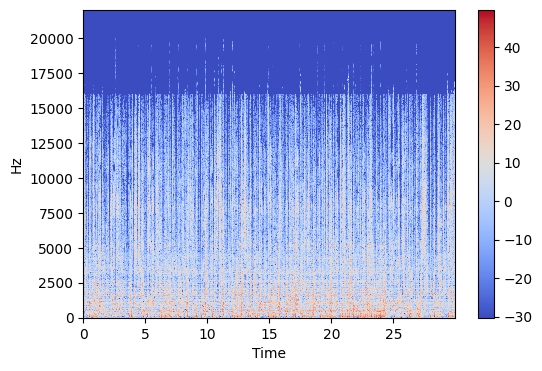

In [40]:
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(6 ,4))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
#librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

(30, 1291)


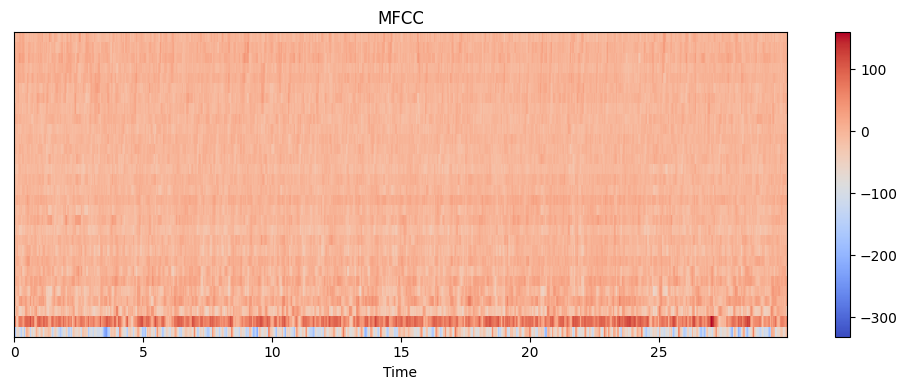

In [54]:

# Calculate MFCCs
mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=30, n_fft=2048, hop_length=512)
print(mfccs.shape)

# Displaying the MFCCs
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()



In [6]:
# len(mfccs)


# standardizing the features

In [108]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, regexp_replace
from pyspark.ml.linalg import Vectors,VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf
from pyspark.sql.functions import size

In [160]:
spark = SparkSession.builder \
    .appName("MongoDB Integration") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/spotify.raw") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/spotify.raw") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.2") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memoryOverhead", "1g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()



In [161]:
df = spark.read.format("mongo").load()
df.printSchema()

root
 |-- _id: integer (nullable = true)
 |-- album_title: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- genres_id: string (nullable = true)
 |-- genres_title: string (nullable = true)
 |-- listens: integer (nullable = true)
 |-- track_title: string (nullable = true)



24/05/12 23:34:26 WARN MongoInferSchema: Field 'album_title' contains conflicting types converting to StringType


In [139]:
df.show(5)

+-----+--------------------+--------------------+--------------------+-------------+--------------------+-------+--------------------+
|  _id|         album_title|         artist_name|            features|    genres_id|        genres_title|listens|         track_title|
+-----+--------------------+--------------------+--------------------+-------------+--------------------+-------+--------------------+
|    2|AWOL - A Way Of Life|                AWOL|[0.34270487547521...|           21|             Hip-Hop|   1293|                Food|
|77753|Agony Through Cer...|       The Scallions|[4.81573632404069...|     1,10,111|Avant-Garde,Pop,P...|    316|Plastragraphic (H...|
|77414|   Ophiuchi [Deluxe]|      theAudiologist|[1.12520214327286...|15,42,236,495|Electronic,Ambien...|    219|         Green Dunes|
|77219|   Great Stewardship|          Gutterhulk|[-2.7457983057791...|           42|  Ambient Electronic|     88|       Into the Lair|
|77378|                  II|BJ Block & Dawn P...|[0.710

In [140]:

#feature sizes
df= df.withColumn("feature_size", size("features"))
df.groupBy("feature_size").count().show()

df = df.withColumn("genres_id", split(regexp_replace(col("genres_id"), "[\\[\\]]", ""), ",\s*").cast("array<int>"))

+------------+-----+
|feature_size|count|
+------------+-----+
|          31|  118|
|          37| 3000|
|          35| 1000|
|          39| 3000|
|          38| 9000|
+------------+-----+



In [141]:
def standardize_features(features, target_length=38):
    if len(features) > target_length:
        return Vectors.dense(features[:target_length])
    elif len(features) < target_length:
        return Vectors.dense(features + [0.0] * (target_length - len(features)))
    return Vectors.dense(features)

rdd = udf(standardize_features, VectorUDT())
df = df.withColumn("features", rdd("features"))


In [142]:
# UDF to calculate the length of each vector
def vector_length(vector):
    return len(vector)

# Register the UDF with the appropriate return type
vector_length_udf = udf(vector_length, IntegerType())

# Apply the UDF to create a new column 'vector_length' on the standardized features
df = df.withColumn("vector_length", vector_length_udf("features"))

# Display the distribution of vector lengths for the standardized features
df.groupBy("vector_length").count().show()

+-------------+-----+
|vector_length|count|
+-------------+-----+
|           38|16118|
+-------------+-----+



In [143]:
print(type(df))
df.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- _id: integer (nullable = true)
 |-- album_title: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- genres_id: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- genres_title: string (nullable = true)
 |-- listens: integer (nullable = true)
 |-- track_title: string (nullable = true)
 |-- feature_size: integer (nullable = false)
 |-- vector_length: integer (nullable = true)



In [144]:
df.show(10)

+-----+--------------------+--------------------+--------------------+------------------+--------------------+-------+--------------------+------------+-------------+
|  _id|         album_title|         artist_name|            features|         genres_id|        genres_title|listens|         track_title|feature_size|vector_length|
+-----+--------------------+--------------------+--------------------+------------------+--------------------+-------+--------------------+------------+-------------+
|    2|AWOL - A Way Of Life|                AWOL|[0.34270487547521...|              [21]|             Hip-Hop|   1293|                Food|          38|           38|
|77753|Agony Through Cer...|       The Scallions|[4.81573632404069...|      [1, 10, 111]|Avant-Garde,Pop,P...|    316|Plastragraphic (H...|          38|           38|
|77414|   Ophiuchi [Deluxe]|      theAudiologist|[1.12520214327286...|[15, 42, 236, 495]|Electronic,Ambien...|    219|         Green Dunes|          38|           38

In [145]:
df = df.drop("feature_size", "vector_length")


In [147]:
# from pyspark.sql.functions import isnan, when, count, col

# # Check for nulls in the features column
# df.select([count(when(col("features").isNull(), True))]).show()

# # Verify the entries are indeed vectors and not other types inadvertently cast
# df.select("features").show(5, truncate=False)

In [148]:
features_df = df.select("features")
features_df.printSchema()


root
 |-- features: vector (nullable = true)



In [149]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt


In [150]:
cost = []
silhouette_scores = []
for k in range(2, 10):  # Test from 2 to 9 clusters
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(features_df)
    predictions = model.transform(features_df)
    
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    
    cost.append(model.summary.trainingCost)  # Collect WSS

# Plotting the results for the Elbow Method
plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 1)
plt.plot(range(2, 10), cost, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')

# Plotting the silhouette scores
plt.subplot(2, 1, 2)
plt.plot(range(2, 10), silhouette_scores, 'go-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores For Optimal k')

plt.tight_layout()
plt.show()

Traceback (most recent call last):                                              
  File "/home/shahbaz/Downloads/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
  File "/home/shahbaz/Downloads/spark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/shahbaz/Downloads/spark/python/lib/pyspark.zip/pyspark/worker.py", line 874, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/shahbaz/Downloads/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 596, in read_int
    raise EOFError
EOFError
24/05/12 23:20:08 WARN BlockManager: Putting block rdd_774_0 failed due to exception java.lang.IllegalArgumentException: Illegal Capacity: -131945808.
24/05/12 23:20:08 WARN BlockManager: Block rdd_774_0 could not be removed as it was not found on disk or in memory
24/05/12 23:20:08 ERROR Executor: Exception in task 0.0 in stage 149.0 (TID 113)
java.lang.IllegalArgumentException: Illegal Capacity: -131945808
	at java.base

Py4JJavaError: An error occurred while calling o1272.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 149.0 failed 1 times, most recent failure: Lost task 0.0 in stage 149.0 (TID 113) (192.168.100.7 executor driver): java.lang.IllegalArgumentException: Illegal Capacity: -131945808
	at java.base/java.util.ArrayList.<init>(ArrayList.java:158)
	at org.apache.spark.sql.execution.python.EvaluatePython$.toJava(EvaluatePython.scala:64)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$3(BatchEvalPythonExec.scala:72)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1161)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1176)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1214)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2790)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2726)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2725)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2725)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1211)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2989)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2928)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2917)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:976)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1269)
	at org.apache.spark.rdd.RDD.$anonfun$takeSample$1(RDD.scala:627)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:408)
	at org.apache.spark.rdd.RDD.takeSample(RDD.scala:616)
	at org.apache.spark.mllib.clustering.KMeans.initKMeansParallel(KMeans.scala:400)
	at org.apache.spark.mllib.clustering.KMeans.runAlgorithmWithWeight(KMeans.scala:273)
	at org.apache.spark.mllib.clustering.KMeans.runWithWeight(KMeans.scala:231)
	at org.apache.spark.ml.clustering.KMeans.trainWithRow(KMeans.scala:446)
	at org.apache.spark.ml.clustering.KMeans.$anonfun$fit$1(KMeans.scala:382)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:371)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.IllegalArgumentException: Illegal Capacity: -131945808
	at java.base/java.util.ArrayList.<init>(ArrayList.java:158)
	at org.apache.spark.sql.execution.python.EvaluatePython$.toJava(EvaluatePython.scala:64)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.$anonfun$evaluate$3(BatchEvalPythonExec.scala:72)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1161)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1176)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1214)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1217)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:320)
	at org.apache.spark.sql.execution.python.PythonUDFRunner$$anon$1.writeIteratorToStream(PythonUDFRunner.scala:57)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.$anonfun$run$1(PythonRunner.scala:440)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:2088)
	at org.apache.spark.api.python.BasePythonRunner$WriterThread.run(PythonRunner.scala:274)


In [151]:
df.describe().show()
df.show(5, truncate=False)


+-------+------------------+--------------------+-----------------+----------------+-----------------+--------------------------------+
|summary|               _id|         album_title|      artist_name|    genres_title|          listens|                     track_title|
+-------+------------------+--------------------+-----------------+----------------+-----------------+--------------------------------+
|  count|             16118|               16118|            16118|           16118|            16118|                           16118|
|   mean|  73927.1298548207|                 NaN|         Infinity|            null|2295.864251147785|                        Infinity|
| stddev|40203.290346524154|                 NaN|              NaN|            null|7517.704983410477|                             NaN|
|    min|                 2|"Demo to London" ...|          (morse)|Afrobeat,African|               12|                              ""|
|    max|            130999|…Serpeggiava Un F...

In [152]:
# Check for any non-numeric characters in supposed numeric fields
df.filter(~df.listens.rlike("^[0-9]+$")).show()
# Check for abnormal entries in categorical fields
df.select("artist_name").distinct().show(truncate=False)


+---+-----------+-----------+--------+---------+------------+-------+-----------+
|_id|album_title|artist_name|features|genres_id|genres_title|listens|track_title|
+---+-----------+-----------+--------+---------+------------+-------+-----------+
+---+-----------+-----------+--------+---------+------------+-------+-----------+

+---------------------------------+
|artist_name                      |
+---------------------------------+
|Hank Hobson                      |
|Mac 68K                          |
|Disco Krete                      |
|Dog Leather                      |
|Ayato and Natalia Kamia          |
|Gino Robair                      |
|DJ Spooky                        |
|The Space Lady a.k.a. Suzy Soundz|
|Real Vocal String Quartet        |
|Maan Aura                        |
|Kyle Gann                        |
|Fabrizio Paterlini               |
|Zap-Pascal                       |
|Electronchis                     |
|Illusion of Safety               |
|Food For Animals      

In [153]:
# Cast listens to integer if it's not already
from pyspark.sql.functions import col
df = df.withColumn("listens", col("listens").cast("integer"))


In [154]:
from pyspark.sql.functions import when
df = df.withColumn("artist_name", when(col("artist_name") == float('inf'), None).otherwise(col("artist_name")))


In [155]:
df = df.withColumn("track_title", col("track_title").cast("string"))


In [156]:
df.describe().show()


+-------+------------------+--------------------+-----------------+----------------+-----------------+--------------------------------+
|summary|               _id|         album_title|      artist_name|    genres_title|          listens|                     track_title|
+-------+------------------+--------------------+-----------------+----------------+-----------------+--------------------------------+
|  count|             16118|               16118|            16113|           16118|            16118|                           16118|
|   mean|  73927.1298548207|                 NaN|             null|            null|2295.864251147785|                        Infinity|
| stddev|40203.290346524154|                 NaN|             null|            null|7517.704983410477|                             NaN|
|    min|                 2|"Demo to London" ...|          (morse)|Afrobeat,African|               12|                              ""|
|    max|            130999|…Serpeggiava Un F...

In [9]:
spark.stop()

In [162]:
import pandas as pd

# Assuming 'df' is your Spark DataFrame
pandas_df = df.toPandas()


/home/shahbaz/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:198: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  An error occurred while calling o1350.pandasStructHandlingMode. Trace:
py4j.Py4JException: Method pandasStructHandlingMode([]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:321)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:329)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java

Py4JError: An error occurred while calling o1350.pandasStructHandlingMode. Trace:
py4j.Py4JException: Method pandasStructHandlingMode([]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:321)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:329)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)

